###Unidade 6  - Recuperação da Informação
Aluno(a): Tainá da Silva Lima
<br>
DRE: 116165607
<br><br>
Aluno(a): Rafael Pais Cardoso
<br>
DRE: 116140788
<br><br>
Professor(a): Giseli Lopes
<br>
Período: 2020.4 PLE

# Importando as bibliotecas necessárias aos exercícios realizados nesse trabalho

In [ ]:
import numpy as np
import math
from prettytable import PrettyTable

# Funções

Pré-processamento da coleção

In [ ]:
# M             --> Vetor coluna onde cada linha representa o texto de um documento (matriz Nx1).
# separadores   --> Vetor linha de caracteres (matriz 1xNc), onde o elemento em cada coluna representa um separador a ser usado na tokenização dos documentos.
# stopwords     --> Vetor linha de strings (matriz 1xNs), onde o elemento em cada coluna armazena uma stopword.
# Essa função aplica as etapas de pré-processamento nos documentos.
def normalizacaoTokenizacao(M, separadores, stopwords):

  matriz = []

  for index in range(0, len(M)):

    # Recebe o texto de um novo documento a cada iteração.
    documentoTemporario = M[index][0]

    # Remoção dos delimitadores e normalização.
    for delimitador in separadores:
      documentoTemporario = documentoTemporario.lower().replace(delimitador, " ")

    # Obtenção dos possíveis tokens
    tokens = documentoTemporario.split()

    # Remoção das stopwords e armazenamento dos tokens em uma matriz Nx1 (cada linha representa um documento e a coluna apresenta a lista de tokens extraídos do documento).
    matriz.append(list(filter(lambda a: a not in stopwords, tokens)))
    
  return matriz

Pré-processamento da consulta

In [ ]:
# consulta      --> String contendo os termos da consulta.
# separadores   --> Vetor linha de caracteres (matriz 1xNc), onde o elemento em cada coluna representa um separador a ser usado na tokenização dos documentos.
# stopwords     --> Vetor linha de strings (matriz 1xNs), onde o elemento em cada coluna armazena uma stopword.
# Essa função aplica as etapas de pré-processamento na consulta.
def tratamentoConsulta(consulta, separadores, stopwords):

  consultaTratada = consulta
  for delimitador in separadores:
      consultaTratada = consultaTratada.lower().replace(delimitador, " ")
  
  consultaTratada = consultaTratada.split()
  
  consultaTratada = list(filter(lambda a: a not in stopwords, consultaTratada))
  
  return consultaTratada

Determinação da frequência do termo no documento

In [ ]:
# termo     --> String contendo um único elemento.
# documento --> Vetor de string (matriz 1x1), que representa o texto de um único documento da coleção.
# Calcula a frequência de um determinado termo em um documento específico.
def freqDoc(termo, documento):
  return documento.count(termo)

Determinação da frequência do termo na coleção

In [ ]:
# termo   --> String contendo um único elemento.
# colecao --> Vetor de string (matriz 1x1), que representa o texto de um único documento da coleção.
# Calcula a frequência de um determinado termo em um documento específico.
def freqCol(termo, colecao):
  contaTermo = 0
  for documento in colecao:
    if(termo in documento):
      contaTermo+= 1
  return contaTermo

Cálculo da similaridade pelo BM25

Aplicamos a fórmula abaixo para calcular a similaridade entre um documento j e uma consulta q:

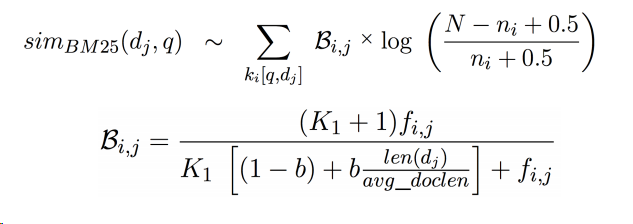

In [ ]:
# matriz --> matriz de tokens Nx1 (cada linha representa um documento e a coluna apresenta a lista de tokens extraídos do documento).
# Essa função cria a matriz de incidências. Essa matriz indica se um determinado token existe em um documento (valor > 0 caso exista. Do contrário, valor = 0), assim como
# a frequência neste documento.
def criarMatrizIncidenciasV2(matriz):

  # A chave do diconário é o token. O valor associado à chave é uma matriz 1x1, em que o elemento dicionarioTokens[token][0][0] representa uma matriz 1xN, sendo que cada coluna está 
  # associada a um respectivo documento e os possíveis valores que podem assumir são maiores ou iguais a 0 (o valor 0 significada que o token não se encontra no documento e o valores
  # maiores do que 0 significam a frequência com aparecem no documento.
  dicionarioTokensV2 = {}

  # Itera sobre os documentos
  for index in range(0, len(matriz)):
    
    # Itera em cada elemento da lista de token
    for token in matriz[index]:

      # Adiciona o token ao dicionário, caso ele não exista. Além disso, seta o valor para 1 para o documento ao qual pertence.
      if(token not in dicionarioTokensV2.keys()):
        x                         = [0]*len(matriz)
        x[index]                  = 1
        dicionarioTokensV2[token] = [x]

      # Incrementa-se a frequência com que aparece no respectivo documento
      else:
          dicionarioTokensV2[token][0][index] += 1
          
  return dicionarioTokensV2

#Função que calcula o tamanho do documento
def sizeDocument (document):
  return len(document)

#Função que calcula o tamanho médio dos documentos da coleção
def averageSizeDocument(colecao):
  avg = 0
  for document in colecao:
    avg += sizeDocument(document)
  
  avg = avg / len(colecao)

  return avg

#Função que calcula o Ni de cada termo
def Ni(frequenciasDoc, termo):
  ni = 0

  for freq in frequenciasDoc[termo][0]:
    if (freq > 0):
      ni+=1

  return ni

#Função que calcula o B para cada termo i e documento j
def B(termo, documento, colecao, frequenciasDoc, K1 = 1, b = 0.85):
  return ( (K1 + 1)*frequenciasDoc[termo][0][documento] ) / ( K1 * ( (1-b) + b*( sizeDocument(colecao[documento])/averageSizeDocument(colecao) ) )  +  frequenciasDoc[termo][0][documento]) 

#Função que calcula a parte do log na conta de similaridade
def logsPart(N, ni):
  return math.log2( (N-ni + 0.5) / (ni + 0.5)  )

#Função que encontra os termos em comum entre a consulta e o documento em questão
def findIntersectionBetween(consulta, documento):
    return list(set(consulta) & set(documento))

#Função que calcula os valores da fórmula de similaridade (valores para o ranking)
def similaridadeBM25(consulta, colecao, N):

  simConsultaDoc = {}

  frequenciasDoc = criarMatrizIncidenciasV2(colecao)

  for i in range(len(colecao)):
    termosEmComum = findIntersectionBetween(consulta, colecao[i])

    sum = 0

    for termo in termosEmComum:
      sum += B(termo, i, colecao, frequenciasDoc) * logsPart(N, Ni(frequenciasDoc, termo))
    
    if i not in simConsultaDoc.keys():
      simConsultaDoc[i] = sum
  
  return simConsultaDoc




# Exemplo 1


Coleção, stopwords, consulta e separadores

In [ ]:
# Conjunto de documentos
M1            = [["O peã e o caval são pec de xadrez. O caval é o melhor do jog."],
                ["A jog envolv a torr, o peã e o rei."],
                ["O peã lac o boi"],
                ["Caval de rodei!"],
                ["Polic o jog no xadrez."]]

# Lista de stopwords
stopwords1    = ["a", "o", "e", "é", "de", "do", "no", "são"]

# String contendo os termos da consulta
q1            = "xadrez peã caval torr"

# Separadores para a tokenizacao
separadores1  = [" ",",",".","!","?"] 

Aplicação do pré-processamento na coleção e na consulta e aplicação do TF-IDF na coleção

In [ ]:
resultadoEx1            = normalizacaoTokenizacao(M1, separadores1, stopwords1)
print("Resultado da normalização e tokenização:")
print(resultadoEx1)
print("\n")

consultaTratadaEx1      = tratamentoConsulta(q1, separadores1, stopwords1)
print("Resultado do tratamento da consulta:")
print(consultaTratadaEx1)
print('\n')

dicRank1 = similaridadeBM25(consultaTratadaEx1, resultadoEx1, len(resultadoEx1))

listRank1 = sorted(dicRank1.items(), key=lambda x: x[1], reverse=True)

print("Ranking:")

tableRank1              = PrettyTable()

column_names1           = ["Posição", "Documento", "Rank"] 
#print(listRank1)

tableRank1.add_column(column_names1[0], [i+1 for i in range(len(listRank1))])
tableRank1.add_column(column_names1[1], [M1[document[0]][0] for document in listRank1])
tableRank1.add_column(column_names1[2], [str(document[1]) for document in listRank1])

print(tableRank1)

Resultado da normalização e tokenização:
[['peã', 'caval', 'pec', 'xadrez', 'caval', 'melhor', 'jog'], ['jog', 'envolv', 'torr', 'peã', 'rei'], ['peã', 'lac', 'boi'], ['caval', 'rodei'], ['polic', 'jog', 'xadrez']]


Resultado do tratamento da consulta:
['xadrez', 'peã', 'caval', 'torr']


Ranking:
+---------+---------------------------------------------------------------+---------------------+
| Posição |                           Documento                           |         Rank        |
+---------+---------------------------------------------------------------+---------------------+
|    1    |              A jog envolv a torr, o peã e o rei.              |  1.0052897586751217 |
|    2    |                        Caval de rodei!                        |  0.5974484026710667 |
|    3    | O peã e o caval são pec de xadrez. O caval é o melhor do jog. |  0.5450406480507977 |
|    4    |                     Polic o jog no xadrez.                    |  0.5356433954981977 |
|    5    |   

# Exemplo 2


Coleção, stopwords, consulta e separadores

In [ ]:
# Conjunto de documentos
M2              = [["Parasita é o grande vencedor do Oscar 2020, com quatro prêmios"],
                  ["Green Book, Roma e Bohemian Rhapsody são os principais vencedores do Oscar 2019"],
                  ["Oscar 2020: Confira lista completa de vencedores. Parasita e 1917 foram os grandes vencedores da noite"],
                  ["Em boa fase, Oscar sonha em jogar a Copa do Mundo da Rússia"],
                  ["Conheça os indicados ao Oscar 2020; Cerimônia de premiação acontece em fevereiro"],
                  ["Oscar Schmidt receberá Troféu no Prêmio Brasil Olímpico 2019. Jogador de basquete com mais pontos em Jogos Olímpicos."],
                  ["Seleção brasileira vai observar de 35 a 40 jogadores para definir lista da Copa América"],
                  ["Oscar 2020: saiba como é a escolha dos jurados e como eles votam"],
                  ["Bem, Amigos! discute lista da Seleção, e Galvão dá recado a Tite: Cadê o Luan?"],
                  ["IFAL-Maceió convoca aprovados em lista de espera do SISU para chamada oral"],
                  ["Arrascaeta e Matías Viña são convocados pelo Uruguai para eliminatórias da Copa. Além deles, há outros destaques na lista."],
                  ["Oscar do Vinho: confira os rótulos de destaque da safra 2018"],
                  ["Parasita é o vencedor da Palma de Ouro no Festival de Cannes"],
                  ["Estatísticas. Brasileirão Série A: Os artilheiros e garçons da temporada 2020"],
                  ["Setembro chegou! Confira o calendário da temporada 2020/2021 do futebol europeu"]]

# Lista de stopwords
stopwords2     = ["a", "o", "e", "é", "de", "do", "da", "no", "na", "são", "dos", "com", "como", "eles", "em", "os", "ao", "para", "pelo"] 

# String contendo os termos da consulta
q2             = "parasita vencedor green"

# Separadores para a tokenizacao
separadores2   = [" ",",",".","!","?",":","/","\\",";" ] 

Aplicação do pré-processamento na coleção e na consulta e aplicação do BM25 na coleção

In [ ]:
resultadoEx2            = normalizacaoTokenizacao(M2, separadores2, stopwords2)
print("Resultado da normalização e tokenização:")
print(resultadoEx2)
print('\n')

consultaTratadaEx2      = tratamentoConsulta(q2, separadores2, stopwords2)
print("Resultado do tratamento da consulta:")
print(consultaTratadaEx2)
print('\n')

dicRank2 = similaridadeBM25(consultaTratadaEx2, resultadoEx2, len(resultadoEx2))

listRank2 = sorted(dicRank2.items(), key=lambda x: x[1], reverse=True)

print("Ranking:")

tableRank2              = PrettyTable()

column_names2           = ["Posição", "Documento", "Rank"] 
#print(listRank2)

tableRank2.add_column(column_names2[0], [i+1 for i in range(len(listRank2))])
tableRank2.add_column(column_names2[1], [M2[document[0]][0] for document in listRank2])
tableRank2.add_column(column_names2[2], [str(document[1]) for document in listRank2])

print(tableRank2)

Resultado da normalização e tokenização:
[['parasita', 'grande', 'vencedor', 'oscar', '2020', 'quatro', 'prêmios'], ['green', 'book', 'roma', 'bohemian', 'rhapsody', 'principais', 'vencedores', 'oscar', '2019'], ['oscar', '2020', 'confira', 'lista', 'completa', 'vencedores', 'parasita', '1917', 'foram', 'grandes', 'vencedores', 'noite'], ['boa', 'fase', 'oscar', 'sonha', 'jogar', 'copa', 'mundo', 'rússia'], ['conheça', 'indicados', 'oscar', '2020', 'cerimônia', 'premiação', 'acontece', 'fevereiro'], ['oscar', 'schmidt', 'receberá', 'troféu', 'prêmio', 'brasil', 'olímpico', '2019', 'jogador', 'basquete', 'mais', 'pontos', 'jogos', 'olímpicos'], ['seleção', 'brasileira', 'vai', 'observar', '35', '40', 'jogadores', 'definir', 'lista', 'copa', 'américa'], ['oscar', '2020', 'saiba', 'escolha', 'jurados', 'votam'], ['bem', 'amigos', 'discute', 'lista', 'seleção', 'galvão', 'dá', 'recado', 'tite', 'cadê', 'luan'], ['ifal-maceió', 'convoca', 'aprovados', 'lista', 'espera', 'sisu', 'chamada', '

# Exemplo 3

Coleção, stopwords, consulta e separadores

In [ ]:
# Conjunto de documentos
M3              = [["To do is to be. To be is to do."],
                  ["To be or not to be. I am what I am."],
                  ["I think therefore I am. Do be do be do."],
                  ["Do do do, da da da. Let it be, let it be."]]

# Lista de stopwords
stopwords3     = [] 


# String contendo os termos da consulta
q3             = "is it"

# Separadores para a tokenizacao
separadores3   = [" ",",",".","!","?",":","/","\\",";" ]           

Aplicação do pré-processamento na coleção e na consulta e aplicação do TF-IDF na coleção

In [ ]:
resultadoEx3            = normalizacaoTokenizacao(M3, separadores3, stopwords3)
print("Resultado da normalização e tokenização:")
print(resultadoEx3)
print('\n')

consultaTratadaEx3      = tratamentoConsulta(q3, separadores3, stopwords3)
print("Resultado do tratamento da consulta:")
print(consultaTratadaEx3)
print('\n')

dicRank3 = similaridadeBM25(consultaTratadaEx3, resultadoEx3, len(resultadoEx3))

listRank3 = sorted(dicRank3.items(), key=lambda x: x[1], reverse=True)

print("Ranking:")

tableRank3              = PrettyTable()

column_names3           = ["Posição", "Documento", "Rank"] 
#print(listRank3)

tableRank3.add_column(column_names3[0], [i+1 for i in range(len(listRank3))])
tableRank3.add_column(column_names3[1], [M3[document[0]][0] for document in listRank3])
tableRank3.add_column(column_names3[2], [str(document[1]) for document in listRank3])

print(tableRank3)

Resultado da normalização e tokenização:
[['to', 'do', 'is', 'to', 'be', 'to', 'be', 'is', 'to', 'do'], ['to', 'be', 'or', 'not', 'to', 'be', 'i', 'am', 'what', 'i', 'am'], ['i', 'think', 'therefore', 'i', 'am', 'do', 'be', 'do', 'be', 'do'], ['do', 'do', 'do', 'da', 'da', 'da', 'let', 'it', 'be', 'let', 'it', 'be']]


Resultado do tratamento da consulta:
['is', 'it']


Ranking:
+---------+-------------------------------------------+--------------------+
| Posição |                 Documento                 |        Rank        |
+---------+-------------------------------------------+--------------------+
|    1    |      To do is to be. To be is to do.      | 1.6627243690776516 |
|    2    | Do do do, da da da. Let it be, let it be. | 1.5778723937701247 |
|    3    |    To be or not to be. I am what I am.    |         0          |
|    4    |  I think therefore I am. Do be do be do.  |         0          |
+---------+-------------------------------------------+--------------------+
